In [1]:
from web3 import Web3, HTTPProvider
import json
import rlp
from eth_typing import HexStr
from eth_utils import to_bytes
import math
import matplotlib.pyplot as plt
import pandas as pd
import json

import numpy as np

In [2]:
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545',request_kwargs={'timeout': 600}))
w3.is_connected()
len(w3.eth.accounts)

251

# Setup

In [3]:
accounts = w3.eth.accounts
keys = json.load(open('./keys.json'))['private_keys']
AbiPath = './build/contracts/'
AMMabi = json.load(open(AbiPath + 'CPAMM.json'))['abi']
Energyabi = json.load(open(AbiPath + 'EnergyToken.json'))['abi']
Moneyabi = json.load(open(AbiPath + 'MoneyToken.json'))['abi']
Testabi = json.load(open(AbiPath + 'Test.json'))['abi']

MoneyToken_address = Web3.to_checksum_address("0xe78A0F7E598Cc8b0Bb87894B0F60dD2a88d6a8Ab")
EnergyToken_address = Web3.to_checksum_address("0x5b1869D9A4C187F2EAa108f3062412ecf0526b24")
Amm_address = Web3.to_checksum_address("0xC89Ce4735882C9F0f0FE26686c53074E09B0D550")

AMMContract = w3.eth.contract(address=Amm_address,abi=AMMabi)
MoneyContract = w3.eth.contract(address=MoneyToken_address,abi=Moneyabi)
EnergyContract = w3.eth.contract(address=EnergyToken_address,abi=Energyabi)
Test = w3.eth.contract(address="0x254dffcd3277C0b1660F6d42EFbB754edaBAbC2B",abi = Testabi)

admin = Web3.to_checksum_address(w3.eth.accounts[0])


# Data

In [42]:
indexes = pd.read_excel("EC_EV_dataset.xlsx",sheet_name ="Indexes")
indexes.set_index("Player ID",inplace=True)

loads = pd.read_excel("EC_EV_dataset.xlsx",sheet_name ="Load")
loads = loads.add_prefix("load")
loads = loads.rename(columns={"loadTime": "Time"})
loads = pd.wide_to_long(loads,stubnames="load",i= "Time",j='ID')

pv = pd.read_excel("EC_EV_dataset.xlsx",sheet_name="PV")
pv = pv.add_prefix("pv_gen")
pv = pv.rename(columns={"pv_genTime": "Time"})
pv = pd.wide_to_long(pv,stubnames="pv_gen",i= "Time",j='ID')

sell_price = pd.read_excel("EC_EV_dataset.xlsx",sheet_name="Sell Price")
sell_price = sell_price.add_prefix("sell_price")
sell_price = sell_price.rename(columns={"sell_priceTime": "Time"})
sell_price = pd.wide_to_long(sell_price,stubnames="sell_price",i= "Time",j='ID')

buy_price = pd.read_excel("EC_EV_dataset.xlsx",sheet_name="Buy Price")
buy_price = buy_price.add_prefix("buy_price")
buy_price = buy_price.rename(columns={"buy_priceTime": "Time"})
buy_price = pd.wide_to_long(buy_price,stubnames="buy_price",i= "Time",j='ID')

times = pd.date_range("00:00","23:45",freq="15min")

data = loads.merge(right= pv,left_index=True,right_index=True).merge(right=buy_price,right_index=True,left_index=True).merge(right=sell_price,right_index=True,left_index=True)
data["clock"] = [times[i-1].time() for i in data.index.get_level_values(0)]
k_upper = data['buy_price'].agg('mean')
k_lower = data['sell_price'].agg('mean')
AMMContract.functions.set_k_lower(int(k_lower*1e18)).transact({'from':admin})
AMMContract.functions.set_k_upper(int(k_upper*1e18)).transact({'from':admin})
AMMContract.functions.set_steepness(int(2.95*1e18)).transact({'from':admin})
AMMContract.functions.set_midpoint(int(1*1e18)).transact({'from':admin})




HexBytes('0x143d01f96e490b311e9c970d4760b3b125621801990af4327875867dab64e638')

<Axes: xlabel='clock'>

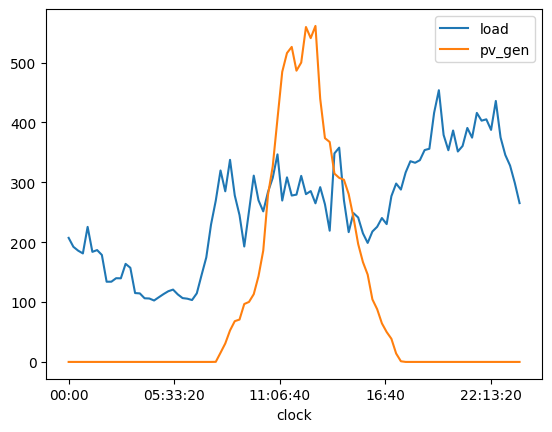

In [44]:
data.groupby(level=[0]).agg({'pv_gen':"sum",'load':"sum","clock":"max"}).plot(x="clock",y=["load","pv_gen"])

In [90]:
data.xs(1,level="ID")

,load,pv_gen,buy_price,sell_price,clock
Time,,,,,
1,1.556923,0.0,0.1073,0.045,00:00:00
2,1.430336,0.0,0.1073,0.045,00:15:00
3,1.304366,0.0,0.1073,0.045,00:30:00
4,1.218622,0.0,0.1073,0.045,00:45:00
5,0.792239,0.0,0.1073,0.045,01:00:00
...,...,...,...,...,...
92,0.273962,0.0,0.1710,0.045,22:45:00
93,0.296229,0.0,0.1710,0.045,23:00:00
94,0.321447,0.0,0.1710,0.045,23:15:00


In [33]:
data.index.get_level_values(0)

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
      dtype='int64', name='Time', length=24000)

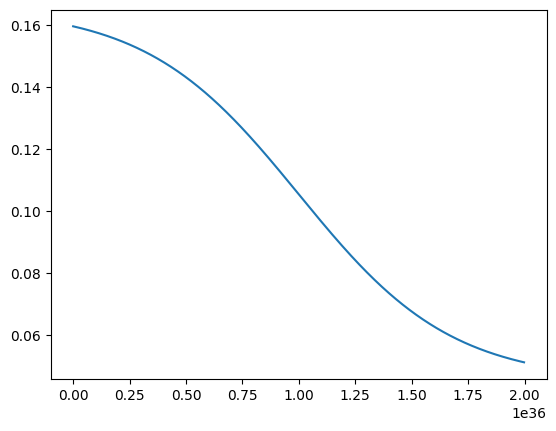

In [10]:
# Testing pricing function
prices = []
rations = []
k_upper = data['buy_price'].agg('mean')
k_lower = data['sell_price'].agg('mean')
AMMContract.functions.set_k_lower(int(k_lower*1e18)).transact({'from':admin})
AMMContract.functions.set_k_upper(int(k_upper*1e18)).transact({'from':admin})
AMMContract.functions.set_steepness(int(2.95*1e18)).transact({'from':admin})
AMMContract.functions.set_midpoint(int(1*1e18)).transact({'from':admin})
for i in range(0,1000):
    price = AMMContract.functions.get_price(int(500*1e18),int(i*1e18)).call()
    prices.append(price/1e18)
    rations.append(i*1e18/500*1e18)

plt.plot(rations,prices)

In [22]:
print(k_lower)
print(k_upper)

0.045
0.16568683333333334


# Simulations

## Full run

In [11]:
# 
data["balance_of_energy"] = np.nan
data["balance_of_money"] =np.nan

k_upper = data['buy_price'].agg('mean')
k_lower = data['sell_price'].agg('mean')
results = {}
for i in range(1,97):
    results[str(i)] = {}
    for j in range (1,251):
        load = data.loc[(i,j),"load"]
        pv_gen = data.loc[(i,j),"pv_gen"]
        address = accounts[j]
        results[str(i)][str(j)] = {"load": load/1e18 , "pv_gen":pv_gen/1e18}
        #print(address)
        #if member needs energy
        print(str(i) + " " + str(j))
        if (load-pv_gen > 0):
            # Fund account
            Funds = int((load-pv_gen)*k_upper*10e18)
            results[str(i)][str(j)]["Money to be transferred to address"] =Funds/1e18
            MoneyContract.functions.transfer(address,Funds).transact({'from':admin})
            results[str(i)][str(j)]["Address Money Balance"] = MoneyContract.functions.balanceOf(address).call()/1e18
            # approve
            MoneyContract.functions.approve(Amm_address,Funds).transact({'from':address})
            results[str(i)][str(j)]["Money Allowance to contract"] = MoneyContract.functions.allowance(address,Amm_address).call()/1e18
            # swap
            AMMContract.functions.swap(MoneyToken_address,Funds).transact({'from':address})
            results[str(i)][str(j)]["Money Balance of contract"] = MoneyContract.functions.balanceOf(Amm_address).call()/1e18
        else: 
            # Fund Energy
            Surplus = int((pv_gen - load)*1e18)
            results[str(i)][str(j)]["Energy to be transferred to address"] =Surplus/1e18

            EnergyContract.functions.transfer(address,Surplus).transact({'from':admin})
            results[str(i)][str(j)]["Address Energy Balance"] = EnergyContract.functions.balanceOf(address).call()/1e18

            # approve
            EnergyContract.functions.approve(Amm_address,Surplus).transact({'from':address})
            results[str(i)][str(j)]["Energy Allowance to contract"] = EnergyContract.functions.allowance(address,Amm_address).call()/1e18
            # swap
            AMMContract.functions.swap(EnergyToken_address,Surplus).transact({'from':address})
            results[str(i)][str(j)]["Energy Balance of contract"] = EnergyContract.functions.balanceOf(Amm_address).call()/1e18

    clear_hash = AMMContract.functions.clear().transact({'from': admin})

with open('data.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(results, f)



            
            


            

        

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184
1 18

In [96]:
# save results
results = []
for i in range(0,96):
    df = pd.DataFrame({"money_in": pd.Series(dtype ='int'),
                    "energy_in":pd.Series(dtype ='int'),
                    "has_deposited":pd.Series(dtype ='bool'),
                    "money_out": pd.Series(dtype ='int'),
                    "energy_out": pd.Series(dtype ='int')})
    for i in range(0,250):
        df.loc[i] = AMMContract.functions.get_member_info(0,accounts[i+1]).call()
        results.append(df)

for i in range(0,250):
    results[i].to_excel("./simulation_results/round"+str(i)+"_results.xlsx")

prices = pd.Series([AMMContract.functions.get_price(i).call()/1e18 for i in range(0,96)])
prices.to_excel("./simulation_results/prices.xlsx")

KeyboardInterrupt: 

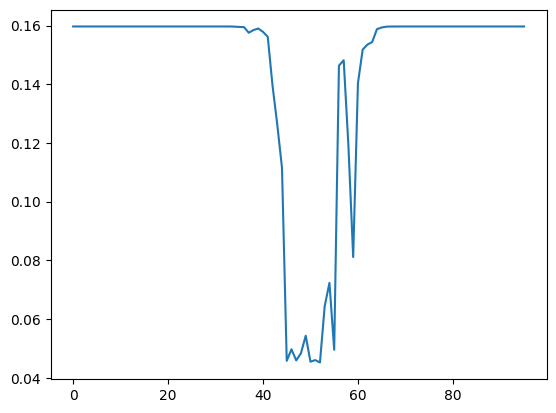

In [93]:
plt.plot(prices)

## Single run

In [169]:
k_upper = data['buy_price'].agg('mean')
k_lower = data['sell_price'].agg('mean')
i=53
# set upper and lower price limit
results = {}
for j in range (1,251):
        load = data.loc[(i,j),"load"]
        pv_gen = data.loc[(i,j),"pv_gen"]
        address = accounts[j]
        results[str(j)] = {"load": load/1e18 , "pv_gen":pv_gen/1e18}
        #print(address)
        #if member needs energy
        print(str(i) + " " + str(j))
        if (load-pv_gen > 0):
            # Fund account
            Funds = int((load-pv_gen)*k_upper*10e18)
            results[str(j)]["Money to be transferred to address"] =Funds
            MoneyContract.functions.transfer(address,Funds).transact({'from':admin})
            results[str(j)]["Address Money Balance"] = MoneyContract.functions.balanceOf(address).call()
            # approve
            MoneyContract.functions.approve(Amm_address,Funds).transact({'from':address})
            results[str(j)]["Money Allowance to contract"] = MoneyContract.functions.allowance(address,Amm_address).call()
            # swap
            AMMContract.functions.swap(MoneyToken_address,Funds).transact({'from':address})
            results[str(j)]["Money Balance of contract"] = MoneyContract.functions.balanceOf(Amm_address).call()
        else: 
            # Fund Energy
            Surplus = int(pv_gen*1e8 - load*1e18)
            results[str(j)]["Energy to be transferred to address"] =Surplus

            EnergyContract.functions.transfer(address,Surplus).transact({'from':admin})
            results[str(j)]["Address Energy Balance"] = EnergyContract.functions.balanceOf(address).call()

            # approve
            EnergyContract.functions.approve(Amm_address,Surplus).transact({'from':address})
            results[str(j)]["Energy Allowance to contract"] = EnergyContract.functions.allowance(address,Amm_address).call()
            # swap
            AMMContract.functions.swap(EnergyToken_address,Surplus).transact({'from':address})
            results[str(j)]["Energy Balance of contract"] = EnergyContract.functions.balanceOf(Amm_address).call()

clear_hash = AMMContract.functions.clear().transact({'from': admin})

with open('data.json', 'w') as f:
    # write the dictionary to the file in JSON format
    json.dump(results, f)


53 1
53 2
53 3
53 4
53 5
53 6
53 7
53 8
53 9
53 10
53 11
53 12
53 13
53 14
53 15
53 16
53 17
53 18
53 19
53 20
53 21
53 22
53 23
53 24
53 25
53 26
53 27
53 28
53 29
53 30
53 31
53 32
53 33
53 34
53 35
53 36
53 37
53 38
53 39
53 40
53 41
53 42
53 43
53 44
53 45
53 46
53 47
53 48
53 49
53 50
53 51
53 52
53 53
53 54
53 55
53 56
53 57
53 58
53 59
53 60
53 61
53 62
53 63
53 64
53 65
53 66
53 67
53 68
53 69
53 70
53 71
53 72
53 73
53 74
53 75
53 76
53 77
53 78
53 79
53 80
53 81
53 82
53 83
53 84
53 85
53 86
53 87
53 88
53 89
53 90
53 91
53 92
53 93
53 94
53 95
53 96
53 97
53 98
53 99
53 100
53 101
53 102
53 103
53 104
53 105
53 106
53 107
53 108
53 109
53 110
53 111
53 112
53 113
53 114
53 115
53 116
53 117
53 118
53 119
53 120
53 121
53 122
53 123
53 124
53 125
53 126
53 127
53 128
53 129
53 130
53 131
53 132
53 133
53 134
53 135
53 136
53 137
53 138
53 139
53 140
53 141
53 142
53 143
53 144
53 145
53 146
53 147
53 148
53 149
53 150
53 151
53 152
53 153
53 154
53 155
53 156
53 157
53 158
53

In [171]:
sum_in_money = 0
sum_out_money = 0
sum_out_energy = 0
sum_in_energy = 0 
for i in range(0,250):
    x = AMMContract.functions.get_member_info(0,accounts[i+1]).call()
    sum_in_money += x[0]
    sum_out_money += x[3]
    sum_in_energy += x[1]
    sum_out_energy += x[4]
print(sum_in_money)
print(sum_out_money)
print(sum_in_energy)
print(sum_out_energy)
print(sum_in_money/AMMContract.functions.get_price(AMMContract.functions.get_reserve0().call(),AMMContract.functions.get_reserve1().call()).call())
print(AMMContract.functions.get_reserve0().call())
print(AMMContract.functions.get_reserve1().call())

114098687130152388922
114098687130152390928
365178012967999998736
365178012967999986287
689.4008203164861
114098687130152388922
365178012967999998736


In [ ]:
129268280086372520584

In [95]:
results = []
for i in range(0,96):
    df = pd.DataFrame({"money_in": pd.Series(dtype ='int'),
                    "energy_in":pd.Series(dtype ='int'),
                    "has_deposited":pd.Series(dtype ='bool'),
                    "money_out": pd.Series(dtype ='int'),
                    "energy_out": pd.Series(dtype ='int')})
    for i in range(0,250):
        df.loc[i] = AMMContract.functions.get_member_info(0,accounts[i+1]).call()
        results.append(df)

results



KeyboardInterrupt: 

In [145]:
print(AMMContract.functions.get_price(AMMContract.functions.get_reserve0().call(),AMMContract.functions.get_reserve1().call()).call()/1e18)
print(k_upper)


0.16568683282453278
0.16568683333333334


In [100]:
diff = sum(df["money_in"].astype('int')) - sum(df["money_out"].astype('int'))

print(sum(df["energy_in"].astype('int')) - sum(df["energy_out"].astype('int')))

126


In [116]:
print(df["money_in"].sum() - df["money_out"].sum())

0.0


In [141]:
AMMContract.functions.get_reserve0().call()

129268280086372520584

In [77]:
print(sum(df["money_in"]))

False


In [119]:
print(AMMContract.functions.get_member_info(0,accounts[1]).call()[0])
print(df["money_in"].astype("int")[0])
print(results["1"]["Money to be transferred to address"])

168278165465456640
168278165465456640
0.16827816546545665


In [17]:
sum  = 0
for log in logs:
    sum += log.args.amount

In [18]:
sum

0

In [12]:
(129268280086372184100 - sum)

-488

In [32]:
reserve0 = AMMContract.functions.get_reserve0().call()
reserve1 = AMMContract.functions.get_reserve1().call()
print(reserve0/1e18)
print(reserve1/1e18)


129.2682800863722
97.430636292


In [15]:
reserve1/1e18

974.3063629200001

In [37]:
pv = data.loc[44,:]['pv_gen'].sum()
load = data.loc[44,:]['load'].sum()
surplus = (data.loc[44,:]['load'] - data.loc[44,:]['pv_gen']).sum()
print(pv)
print(load)
print(surplus)


326.852720604
307.44172985999995
-19.410990744000003


: 

In [21]:
results

{'1': {'load': np.float64(1.636515562e-18),
  'pv_gen': np.float64(2.602242928e-18),
  'Energy to be transferred to address': 0.9657273659999999,
  'Address Energy Balance': 965727365999999872,
  'Energy Allowance to contract': 965727365999999872,
  'Energy Balance of contract': 965727365999999872},
 '2': {'load': np.float64(2.29475499e-19),
  'pv_gen': np.float64(0.0),
  'Money to be transferred to address': 0.380210687568965,
  'Address Money Balance': 380210687568964992,
  'Money Allowance to contract': 380210687568964992,
  'Money Balance of contract': 380210687568964992},
 '3': {'load': np.float64(1.15630063e-19),
  'pv_gen': np.float64(0.0),
  'Money to be transferred to address': 0.19158378976603838,
  'Address Money Balance': 191583789766038368,
  'Money Allowance to contract': 191583789766038368,
  'Money Balance of contract': 571794477335003360},
 '4': {'load': np.float64(2.9148741299999998e-19),
  'pv_gen': np.float64(6.644406579999999e-19),
  'Energy to be transferred to ad

In [ ]:
for index,row in indexes.iterrows():
    

In [148]:
#Add 50 Liquidity to AMM
MoneyContract.functions.approve(Amm_address,50*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})
EnergyContract.functions.approve(Amm_address,50*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

AMMContract.functions.addLiquidity(50*10**18,50*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

HexBytes('0x39c8263cdd8bceb7acdcc31e09f7b7a5baed64e87653cacf3df1b11b64b2aaad')

In [151]:
MoneyContract.functions.approve(Amm_address,50*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})
#Swap Energy to Money
AMMContract.functions.swap(MoneyToken_address,20*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

HexBytes('0x70e767b08f58dd0beeb6ddc24a910d3b8acdaa45c57b368be5346a8b9faf0d40')

In [144]:
MoneyContract.functions.approve("0x254dffcd3277C0b1660F6d42EFbB754edaBAbC2B",5*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

HexBytes('0x274658551076f44eb41cfbfa2a7aafd8b78252a14e54a90b24f851a76c7d016e')

In [145]:
x = Test.functions.send(5 * 10 ** 18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

In [147]:
MoneyContract.functions.balanceOf("0x254dffcd3277C0b1660F6d42EFbB754edaBAbC2B").call()

5000000000000000000

In [138]:
MoneyContract.functions.transferFrom(me,accounts[1],3*10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

HexBytes('0x923cae33742b7694490d5925fe6bc94137b89b27c40a1f99c94a520a3c155713')

In [121]:
5 * 10**18

5000000000000000000

In [123]:
Test.functions.send(5 * 10**18).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

Test.functions.add

ABIFunctionNotFound: ("The function 'send' was not found in this contract's abi.", ' Are you sure you provided the correct contract abi?')

In [152]:
print("Money: " + str(MoneyContract.functions.balanceOf(accounts[0]).call()) )
print("Energy: " + str(EnergyContract.functions.balanceOf(me).call()) )
print("AMM: "+ str(AMMContract.functions.get_reserve0().call()))

Money: 6999925000000000000000000
Energy: 6999969940000000000000000
AMM: 70000000000000000000


In [111]:
x= AMMContract.functions.addLiquidity(3000000000000000000,3000000000000000000).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

In [112]:
y = AMMContract.functions.swap(MoneyToken_address,3 * 10**decimals).transact({"from":me,"nonce": w3.eth.get_transaction_count(me),"gas":2000000,"gasPrice":w3.eth.gas_price})

In [95]:
AMMContract.functions.totalSupply().call()

0

In [88]:
w3.eth.get_transaction_receipt(x)


AttributeDict({'transactionHash': HexBytes('0xbd6153cd8d4943b87a50428dd623c7b039b55b9ede10ba1e0e68ae32604bc6ef'),
 'transactionIndex': 0,
 'blockNumber': 4,
 'blockHash': HexBytes('0x9c9086ca91576d777bb1134f17f062a9267c5894721f8801660dd927e47ee0c9'),
 'from': '0x90F8bf6A479f320ead074411a4B0e7944Ea8c9C1',
 'to': '0xCfEB869F69431e42cdB54A4F4f105C19C080A601',
 'cumulativeGasUsed': 29054,
 'gasUsed': 29054,
 'contractAddress': None,
 'logs': [],
 'logsBloom': HexBytes('0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'),
 'status': 0

In [40]:
#MoneyContract.functions.transfer(accounts[1],7 * (10 ** decimal)).stransact({"from":me})
txs = rlp.decode(hex_to_bytes("0xf8a910850684ee180082e48694a0b86991c6218b36c1d19d4a2e9eb0ce3606eb4880b844a9059cbb000000000000000000000000b8b59a7bc828e6074a4dd00fa422ee6b92703f9200000000000000000000000000000000000000000000000000000000010366401ba0e2a4093875682ac6a1da94cdcc0a783fe61a7273d98e1ebfe77ace9cab91a120a00f553e48f3496b7329a7c0008b3531dd29490c517ad28b0e6c1fba03b79a1dee"), x)
txs.to_dict()

NameError: name 'to_bytes' is not defined

In [72]:
AMMContract.functions

AttributeError: 'Contract' object has no attribute 'methods'

In [13]:
MoneyToken_address = Web3.to_checksum_address("0xe78A0F7E598Cc8b0Bb87894B0F60dD2a88d6a8Ab")
EnergyToken_address = Web3.to_checksum_address("0x5b1869D9A4C187F2EAa108f3062412ecf0526b24")
Amm = Web3.to_checksum_address("0xC89Ce4735882C9F0f0FE26686c53074E09B0D550")

def swapMoney(address,amount):
    
    AMMContract.functions.swap(MoneyToken_address,amount)

In [5]:
# Get Contract
contract_address =Web3.to_checksum_address("0x5fbdb2315678afecb367f032d93f642f64180aa3")
contract = w3.eth.contract(address=contract_address,abi = abi)

In [14]:
contract = w3.eth.contract(address=Amm,abi = abi)